In [2]:
import numpy as np
import scipy.spatial.distance as dist

In [1]:
class UnionFind:
    
    def __init__(self, N):
        self.parent = np.array([-1] * (2*N-1))
        self.next_label = N
        self.size = np.array([1] * N)
        self.size = np.concatenate([self.size, np.array([0] * (N-1))])
        
    def union(self, m, n):
        self.size[self.next_label] = self.size[m] + self.size[n]
        self.parent[m] = self.next_label
        self.parent[n] = self.next_label
        self.size[self.next_label] = self.size[m] + self.size[n]
        self.next_label += 1
        
    def find(self, n):
        while self.parent[n] != -1 :
            n = self.parent[n]
        return n
    
    def fast_find(self, n):
        p = n
        while self.parent[n] != -1 :
            n = self.parent[n]
        while self.parent[p] != n: # label all the way up to the root
            (p, self.parent[p]) = (self.parent[p], n)
        return n

In [23]:
class Hdbscan:
    
    def label(self, L, do_fast_find=True):
        LL = []
        N = len(L) + 1 # QUESTION: why isn't this len(L)??
        U = UnionFind(N)
        for idx, (a, b, delta) in enumerate(L):
            if do_fast_find:
                aa, bb = (U.fast_find(a), U.fast_find(b))
            else:
                aa, bb = (U.find(a), U.find(b))
            LL.append((aa, bb, delta, U.size[aa] + U.size[bb]))      
            U.union(aa, bb)
        return LL

    def base_mst_linkage_core(self, node_labels, distance_matrix):
        result = []
        current_node = np.random.choice(node_labels)
        level_distances = np.infty * np.ones((node_labels.shape[0], node_labels.shape[0]))
        current_labels = node_labels
        for i in xrange(1,node_labels.shape[0]):
            current_labels = current_labels[current_labels != current_node]
            for other_node in current_labels:
                level_distances[i][other_node] = min(level_distances[i-1][other_node], 
                                                    distance_matrix[other_node,current_node])

            new_node_index = np.argmin(level_distances[i][current_labels])
            new_node = current_labels[new_node_index]
            result.append([current_node, new_node, level_distances[i][new_node]])
            current_node = new_node
        return result
    
    def linkage(self, data):
        distance_matrix = dist.squareform(dist.pdist(data))
        labels = np.arange(len(data))
        hierarchy = np.array(self.base_mst_linkage_core(labels, distance_matrix))
        sort_order = np.argsort(hierarchy.T[2])
        data_for_steve = hierarchy[sort_order,:]
        return self.label(data_for_steve)

## Test

In [37]:
import sklearn.datasets

In [38]:
iris = sklearn.datasets.load_iris()

In [39]:
clu = Hdbscan()

In [40]:
z = clu.linkage(iris.data)

In [68]:
import scipy.cluster.hierarchy as hac
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)


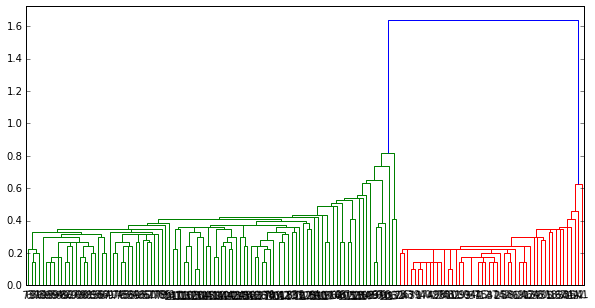

In [69]:
R = hac.dendrogram(z)

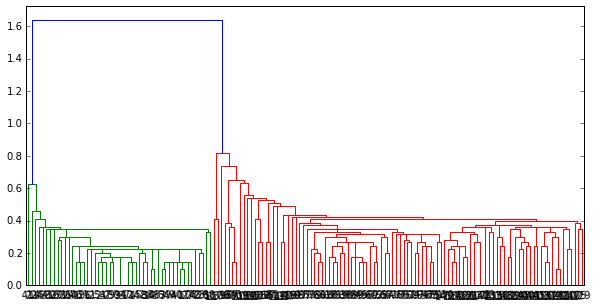

In [70]:
R = hac.dendrogram(hac.linkage(iris.data))